Compare average cloud cover preditions at 1500m for the ten days from *plotting_I1_I2_I3_geographical.ipynb* between
- Our derived analytical equation
- The Sundqvist scheme
- The Xu-Randall scheme
- Coarse-grained DYAMOND
- ERA5 reanalysis

In [1]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import psyplot.project as psy
import sys

In [2]:
# Scaling parameters
all_possible_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U', 'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
            'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz', 'rh_z', 'rh_zz']

loc_all = {}
for i in range(len(all_possible_features)):
    loc_all[all_possible_features[i]] = i
features = ['rh', 'ta', 'clw', 'cli', 'rh_z']
    
# Scale the data
mean_all = [4.12205844e-03,2.25493498e-05,3.38180032e-06,2.57065512e+02,6.00030443e+04,5.64080139e+03,2.35046400e-01,1.32776682e+01,6.02512234e-01,9.86270417e+04,-1.27545273e-06,-4.02484958e-10,1.65204582e-08,-4.34660202e-11,4.29441131e-10,-1.82817316e-12,-4.68742483e-03,-7.54899040e-07,-7.51544542e+00,-1.06989723e-04,1.65615172e-03,-9.27604679e-06,-4.76200071e-05,-1.32246548e-07]
std_all = [5.07648249e-03,5.69702638e-05,1.01308124e-05,3.00533874e+01,3.12514292e+04,5.66963918e+03,4.11184302e-01,1.11389888e+01,3.32494615e-01,6.24039256e+03,2.03179260e-06,1.17041141e-08,1.33311867e-07,1.42840744e-09,6.73384546e-09,5.07424672e-11,5.82875686e-03,6.34826092e-05,3.53136052e+00,1.13215264e-02,6.62892130e-03,6.08144307e-05,2.58065098e-04,2.49552692e-06]

mean = np.concatenate([np.expand_dims(mean_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)
std = np.concatenate([np.expand_dims(std_all[loc_all[sel_var]], axis=0) for sel_var in features], axis = 0)

In [27]:
# See ~/workspace_icon-ml/symbolic_regression/finding_symmetries/pysr_results_dyamond_on_regimes/no_of_regimes_2/notes.txt
def func_PySR(rh, ta, clw, cli, rh_z):
    
    (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (203, 0.06588, 0.03969, 33.87, 4224.6, 18.9586, 2202.6, 20000000000, 60000000, 8641, 32544, 0.0106, 1, 1)
    
    # Modified to always satisfy RH-constraint
    rh = np.maximum(rh, -a_2/(2*a_1)*ta**2 + a_4/(2*a_1)*ta - a_5/(2*a_1))
    
    I1 = a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7
    I2 = (rh_z)**2*(a_8*rh_z+a_9) 
    I3 = -B/(a_10*clw+a_11*cli+eps)
    
    return I1,I2,I3

def func_PySR_era5_tuned(rh, ta, clw, cli, rh_z):
    
    x0 = (rh - mean[0])/std[0]
    x1 = (ta - mean[1])/std[1]
    x2 = (clw - mean[2])/std[2]
    x3 = (cli - mean[3])/std[3]
    x4 = (rh_z - mean[4])/std[4]
    
    (a,b,c,d,e,f,g,h,i,j) = (39.00553647200795, 42.03463110460265, 6.465638378846791, 2.261470694652524, 0.04262325503419716,\
                         0.502986898449626, 31.168968461162308, 11.400469972670322, 0.6233673793100785, 0.7307425434498263)    
    
    # Modified to always satisfy RH-constraint
    x0 = np.maximum(x0, 1/(2*c*d)*(-c*x1**2-a))
    
    return np.maximum(np.minimum(a*x0 - b*x1 + c*x0*(d*x0 + x1**2) + x4**2*(e*x4 + f) + g - h/(x2 + i*x3 + j),100),0)

In [28]:
# def func_sundqvist(rh, pa, ps, fr_land):    
#     rsat_land,r0_top_land,r0_surf_land,n_land,rsat_sea,r0_top_sea,r0_surf_sea,n_sea = (0.9, -1.09295798, 0.26120655, 1.11998966, 0.96270524, -1.58936336, 0.62057541, 0.97892053)
#     r0 = np.where(fr_land > 0.5, r0_top_land + (r0_surf_land - r0_top_land)*np.exp(1-(ps/pa)**n_land), r0_top_sea + (r0_surf_sea - r0_top_sea)*np.exp(1-(ps/pa)**n_sea))
#     c = np.where(rh > r0, 100*(1-np.sqrt((np.minimum(rh, rsat_sea) - rsat_sea)/(r0 - rsat_sea))), 0)
#     return np.minimum(np.maximum(c, 0), 100)
    
def func_xu_randall(rh, clw, cli):
    (PAR, ALPHA) = (0.9105, 913984.9624)
    c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))
    # c can exceed 1 very slightly
    c = np.minimum(c, 1)
    return 100*c

def func_xu_randall_era5_tuned(rh, clw, cli):
    (PAR, ALPHA) = (0.7034445919670529, 15146.081815378784)
    c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))
    # c can exceed 1 very slightly
    c = np.minimum(c, 1)
    return 100*c

In [29]:
# Add derivatives
def compute_derivatives(data_dict):
    assert data_dict['zg'].shape == (24, 27, 81920)
    assert data_dict['rh'].shape == (24, 27, 81920)

    data_dict['rh_z'] = 1000*np.ones((24, 27, 81920))
    data_dict['rh_z'][:, 1:] = (data_dict['rh'][:, :-1] - data_dict['rh'][:, 1:])/(data_dict['zg'][:, :-1] - data_dict['zg'][:, 1:])
    data_dict['rh_z'][:, 0] = data_dict['rh_z'][:, 1] # Fill upper-most derivative values with values from second upper-most layer 
    
    assert np.sum(np.abs(data_dict['rh_z'] - 1000) < 1e-6) == 0
    
    return data_dict['rh_z']

In [30]:
days_summer = ['20160811', '20160812', '20160813', '20160814', '20160815', \
               '20160816', '20160817', '20160818', '20160819', '20160820']

days_summer_era5 = ['2016-08-11', '2016-08-12', '2016-08-13', '2016-08-14', '2016-08-15', \
               '2016-08-16', '2016-08-17', '2016-08-18', '2016-08-19', '2016-08-20']

In [60]:
# For DYAMOND SUMMER days
dya_nc_path = '/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/'
var_names = ['clw', 'cli', 'ta', 'pa', 'hus']

for day_summer in days_summer:
    print(day_summer)
    data = {}
    for var_name in var_names:
        file_path = os.path.join(dya_nc_path, var_name, \
                    'int_var_nwp_R2B10_lkm1007_atm_3d_' + var_name + '_ml_' + day_summer + 'T000000Z_R02B05.nc')

        # Load files with xarray
        file_ds = xr.open_dataset(file_path)

        data[var_name] = getattr(file_ds, var_name).values[:, 4:]

    # Compute RH
    T0 = 273.15
    data['rh'] = 0.00263*data['pa']*data['hus']*np.exp((17.67*(data['ta']-T0))/(data['ta']-29.65))**(-1)
    
    # Compute RH_z
    DS = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/zg/zg*')
    data_dict = {}
    data_dict['zg'] = DS.zg.values
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], axis=0)[:, 4:], 8, axis=0)
    data_dict['rh'] = data['rh']
    
#     ## PySR equation ##
#     data['rh_z'] = compute_derivatives(data_dict)
    
#     # Compute I1, I2, I3 for this day
#     _, I2, _ = func_PySR(data['rh'],data['ta'],data['clw'],data['cli'],data['rh_z'])
    
#     # Save I2 in DataArrays
#     I2_new_da = xr.DataArray(I2, coords={'time':file_ds.time, 'height':file_ds.height[4:31]}, dims=['time', 'height', 'cells'], name='I2_fe')

#     # Save I2 in new netcdf files
#     I2_new_da.to_netcdf('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I2_fe/' + 'I2_' + day_summer + '.nc')
    
    ## Xu-Randall scheme ##
    if day_summer == days_summer[0]:
        pred_xu_randall = func_xu_randall(data['rh'],data['clw'],data['cli'])
    else:
        preds = func_xu_randall(data['rh'],data['clw'],data['cli'])
        pred_xu_randall = np.append(pred_xu_randall, preds, axis=0)

20160811
20160812
20160813
20160814
20160815
20160816
20160817
20160818
20160819
20160820


In [31]:
# For ERA5 days
era5_nc_path = '/home/b/b309170/bd1179_work/ERA5/hvcg_data/1608'
var_names = ['ciwc', 't', 'pa', 'q', 'clwc']
var_codes = ['247', '130', 'pa', '133', '246']

for day_summer in days_summer_era5:
    print(day_summer)
    data = {}
    for ind in range(5):
        file_path = os.path.join(era5_nc_path, \
                    'int_var_E5ml00_1H_' + day_summer + '_' + var_codes[ind] + '_R02B05.nc')

        # Load files with xarray
        file_ds = xr.open_dataset(file_path)

        data[var_names[ind]] = getattr(file_ds, var_names[ind]).values[:, 4:]

    # Compute RH
    T0 = 273.15
    data['rh'] = 0.00263*data['pa']*data['q']*np.exp((17.67*(data['t']-T0))/(data['t']-29.65))**(-1)
    
    # Compute RH_z
    DS = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/zg/zg*')
    data_dict = {}
    data_dict['zg'] = DS.zg.values
    data_dict['zg'] = np.repeat(np.expand_dims(data_dict['zg'], axis=0)[:, 4:], 24, axis=0)
    data_dict['rh'] = data['rh']
    
    ## PySR equation ##
    data['rh_z'] = compute_derivatives(data_dict)
    
    if day_summer == days_summer_era5[0]:
        pred_pysr_era5 = func_PySR_era5_tuned(data['rh'],data['t'],data['clwc'],data['ciwc'],data['rh_z'])
    else:
        preds = func_PySR_era5_tuned(data['rh'],data['t'],data['clwc'],data['ciwc'],data['rh_z'])
        pred_pysr_era5 = np.append(pred_pysr_era5, preds, axis=0)
    
    ## Xu-Randall scheme ##
    if day_summer == days_summer_era5[0]:
        pred_xu_randall_era5 = func_xu_randall_era5_tuned(data['rh'],data['clwc'],data['ciwc'])
    else:
        preds = func_xu_randall_era5_tuned(data['rh'],data['clwc'],data['ciwc'])
        pred_xu_randall_era5 = np.append(pred_xu_randall_era5, preds, axis=0)

2016-08-11


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-12


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-13


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-14


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-15


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-16


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-17


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-18


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-19


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


2016-08-20


/tmp/ipykernel_1120186/1726623778.py:16: RuntimeWarning: invalid value encountered in power
  c = rh**PAR*(1-np.exp(-ALPHA*(cli+clw)))


In [82]:
# Coarse-grained DYAMOND cloud cover
path_dya = '/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/cl_area/'
DS_dya1 = xr.open_mfdataset(path_dya+'int_var_nwp_R2B10_lkm1007_atm_3d_clc_ml_2016081[1-9]T000000Z_R02B05.nc')
DS_dya2 = xr.open_dataset(path_dya+'int_var_nwp_R2B10_lkm1007_atm_3d_clc_ml_20160820T000000Z_R02B05.nc')
DS_dya = xr.concat([DS_dya1, DS_dya2], dim='time')

DS_dya_timmean = DS_dya.mean(dim='time')

In [40]:
# Coarse-grained ERA5 cloud cover
path_era5 = '/home/b/b309170/bd1179_work/ERA5/hvcg_data/1608/'
DS_era5_1 = xr.open_mfdataset(path_era5 + 'int_var_E5ml00_1H_2016-08-1[1-9]_248_R02B05.nc')
DS_era5_2 = xr.open_mfdataset(path_era5 + 'int_var_E5ml00_1H_2016-08-20_248_R02B05.nc')
DS_era5 = xr.concat([DS_era5_1, DS_era5_2], dim='time')

DS_era5_timmean = DS_era5.mean(dim='time')

### Plots

In [79]:
cmap = 'Blues_r'

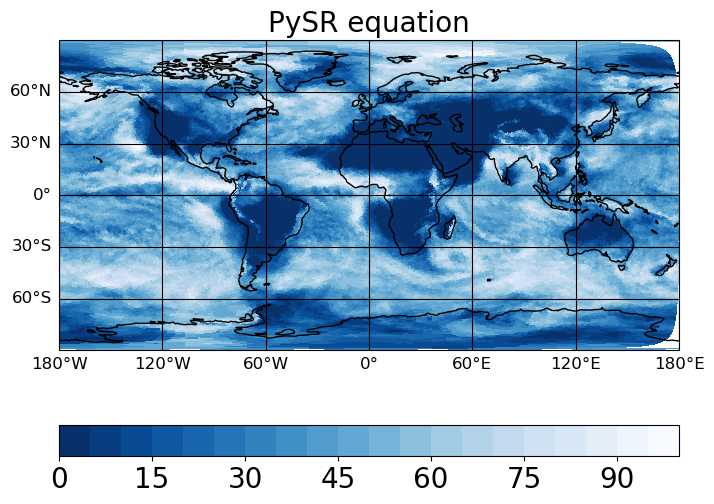

In [238]:
# This is the sum of I1, I2 and I3
plot = psy.plot.mapplot('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_bounded_20160811-0820_timmean.nc', name=['I1'], \
                        height=[20], time=[0], ax=(1, 1), sort=['height'], title = 'PySR equation', titlesize=20, cticksize=20, \
                        bounds=np.linspace(0, 100, 21), cmap=cmap)

plt.savefig('for_pierre/I123_lv_41_20160811-0820_timmean.pdf')

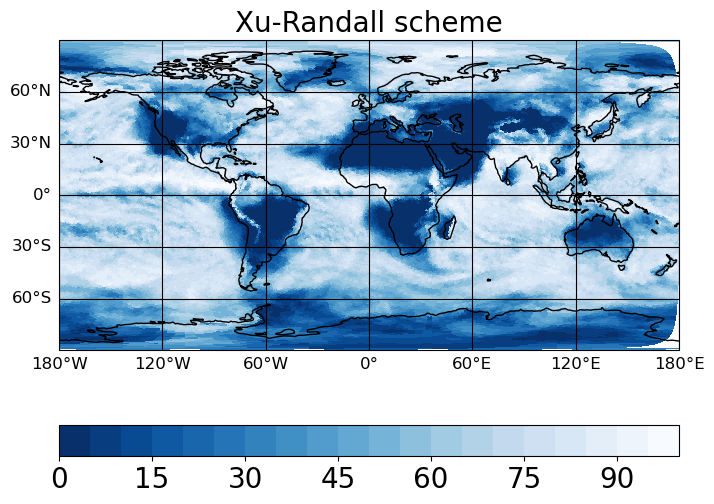

In [239]:
# Placeholder file
DS_xu_randall = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

timmean_xu_randall = np.mean(pred_xu_randall, axis=0)
assert timmean_xu_randall.shape == (27, 81920)

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_xu_randall['I1'][0] = timmean_xu_randall

coordlist = ["clat_bnds", "clon_bnds"]
DS_xu_randall = DS_xu_randall.set_coords([coord for coord in DS_xu_randall.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_xu_randall, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'Xu-Randall scheme', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

assert len(xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I1/20160811-0820_timmean.nc').height) == len(DS_xu_randall.height)

plt.savefig('for_pierre/xu-randall_lv_41_20160811-0820_timmean.pdf')

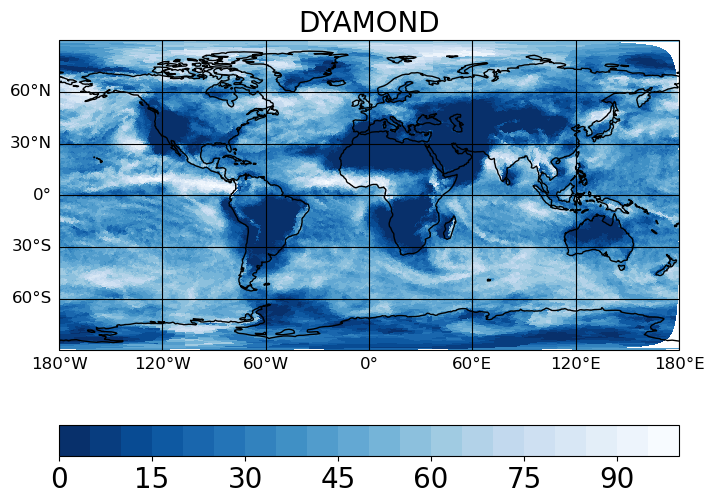

In [240]:
# Placeholder file
DS_dya_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_dya_new['I1'][0] = 100*DS_dya_timmean.cl_area.values[4:]

coordlist = ["clat_bnds", "clon_bnds"]
DS_dya_new = DS_dya_new.set_coords([coord for coord in DS_dya_new.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_dya_new, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'DYAMOND', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

assert len(DS_xu_randall.height) == len(DS_dya_new.height)

plt.savefig('for_pierre/dyamond_lv_41_20160811-0820_timmean.pdf')

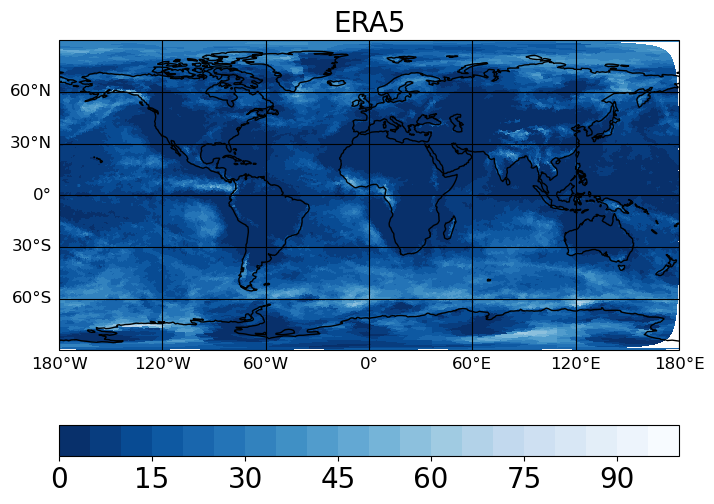

In [11]:
# Placeholder file
DS_era5_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_era5_new['I1'][0] = 100*DS_era5_timmean.cc.values[4:]

coordlist = ["clat_bnds", "clon_bnds"]
DS_era5_new = DS_era5_new.set_coords([coord for coord in DS_era5_new.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_era5_new, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

assert 27 == len(DS_era5_new.height)

plt.savefig('for_pierre/era5_lv_41_20160811-0820_timmean.pdf')

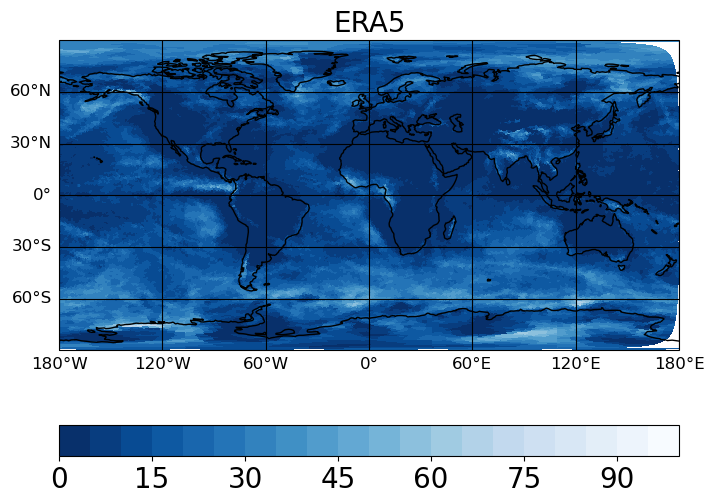

In [84]:
# Considering only the three-hourly data!
DS_era5_timmean = DS_era5.cc[::3].mean(dim='time')

# Placeholder file
DS_era5_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_era5_new['I1'][0] = 100*DS_era5_timmean.values[4:]

coordlist = ["clat_bnds", "clon_bnds"]
DS_era5_new = DS_era5_new.set_coords([coord for coord in DS_era5_new.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_era5_new, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

assert 27 == len(DS_era5_new.height)

# Differences are less then 5%, so it makes no difference which average to plot.

**Tuned PySR and Xu-Randall schemes on ERA5 data**

In [44]:
cmap = 'Blues_r'

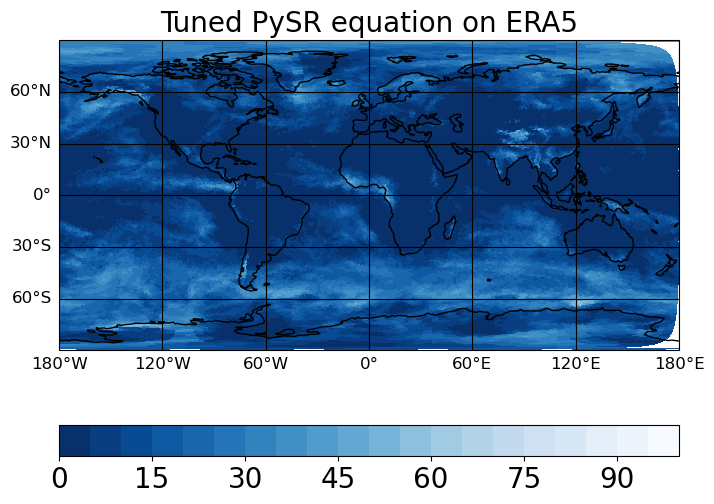

In [45]:
# Placeholder file
DS_pysr_era5 = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

timmean_pysr_era5 = np.mean(pred_pysr_era5[::3], axis=0)
assert timmean_pysr_era5.shape == (27, 81920)

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_pysr_era5['I1'][0] = timmean_pysr_era5

coordlist = ["clat_bnds", "clon_bnds"]
DS_pysr_era5 = DS_pysr_era5.set_coords([coord for coord in DS_pysr_era5.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_pysr_era5, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'Tuned PySR equation on ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

plt.savefig('for_pierre/I123_tuned_on_era5_lv_41_20160811-0820_timmean.pdf')

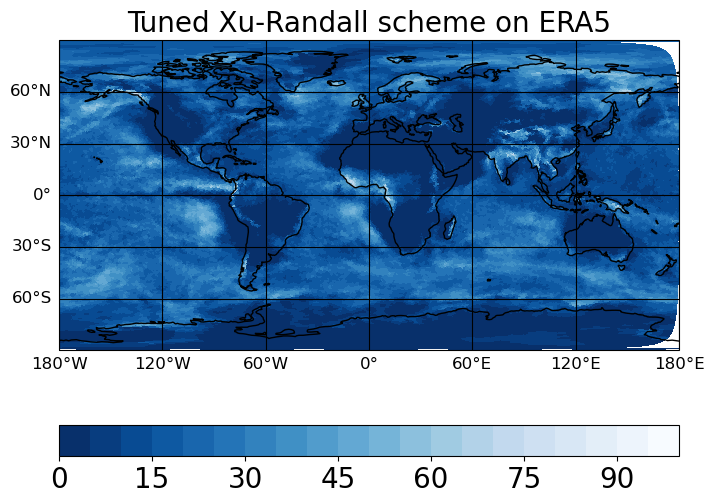

In [25]:
# Placeholder file
DS_xu_randall_era5 = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

timmean_xu_randall_era5 = np.mean(pred_xu_randall_era5[::3], axis=0)
assert timmean_xu_randall_era5.shape == (27, 81920)

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_xu_randall_era5['I1'][0] = timmean_xu_randall_era5 - DS_era5_timmean

coordlist = ["clat_bnds", "clon_bnds"]
DS_xu_randall_era5 = DS_xu_randall_era5.set_coords([coord for coord in DS_xu_randall_era5.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_xu_randall_era5, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'Tuned Xu-Randall scheme on ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

plt.savefig('for_pierre/xu-randall_tuned_on_era5_lv_41_20160811-0820_timmean.pdf')

**Corresponding biases w.r.t. ERA5**

In [36]:
cmap = 'bwr'

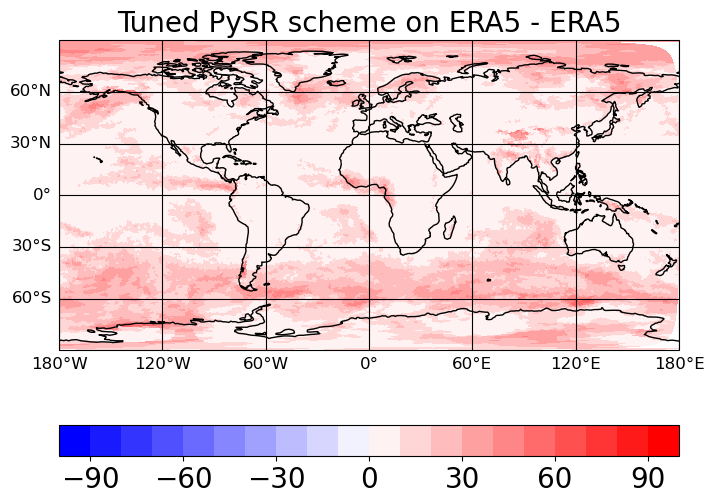

In [37]:
# Placeholder file
DS_pysr_era5 = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

timmean_pysr_era5 = np.mean(pred_pysr_era5[::3], axis=0)
assert timmean_pysr_era5.shape == (27, 81920)

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_pysr_era5['I1'][0] = timmean_pysr_era5

coordlist = ["clat_bnds", "clon_bnds"]
DS_pysr_era5 = DS_pysr_era5.set_coords([coord for coord in DS_pysr_era5.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_pysr_era5, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'Tuned PySR scheme on ERA5 - ERA5', titlesize=20, cticksize=20, bounds=np.linspace(-100, 100, 21), cmap=cmap)

plt.savefig('for_pierre/I123_tuned_on_era5_bias_lv_41_20160811-0820_timmean.pdf')

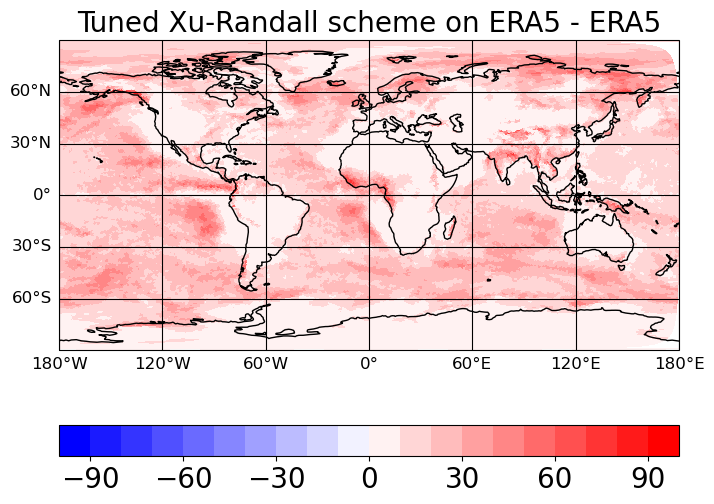

In [38]:
# Placeholder file
DS_xu_randall_era5 = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

timmean_xu_randall_era5 = np.mean(pred_xu_randall_era5[::3], axis=0)
assert timmean_xu_randall_era5.shape == (27, 81920)

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_xu_randall_era5['I1'][0] = timmean_xu_randall_era5

coordlist = ["clat_bnds", "clon_bnds"]
DS_xu_randall_era5 = DS_xu_randall_era5.set_coords([coord for coord in DS_xu_randall_era5.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_xu_randall_era5, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'Tuned Xu-Randall scheme on ERA5 - ERA5', titlesize=20, cticksize=20, bounds=np.linspace(-100, 100, 21), cmap=cmap)

plt.savefig('for_pierre/xu-randall_tuned_on_era5_bias_lv_41_20160811-0820_timmean.pdf')

**Some tests of the ERA5 cloud cover**

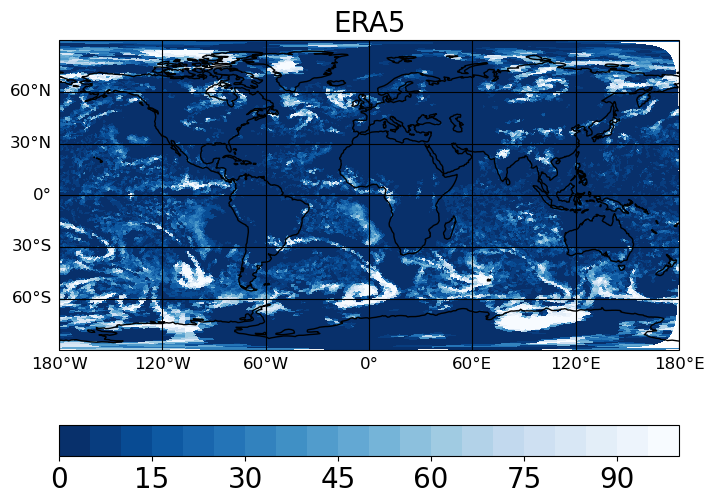

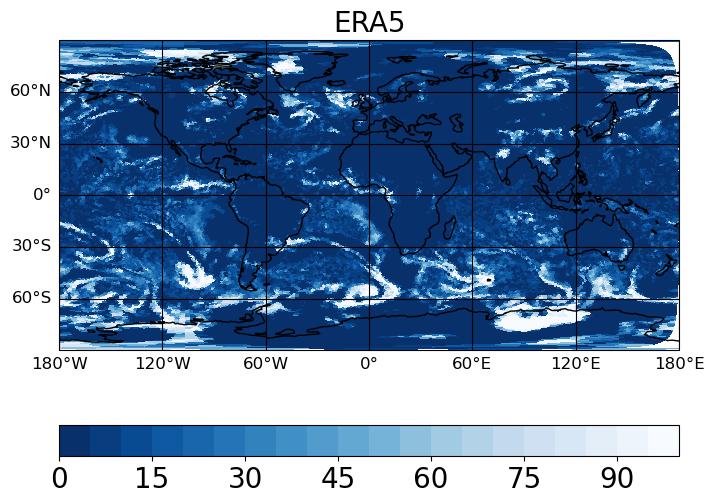

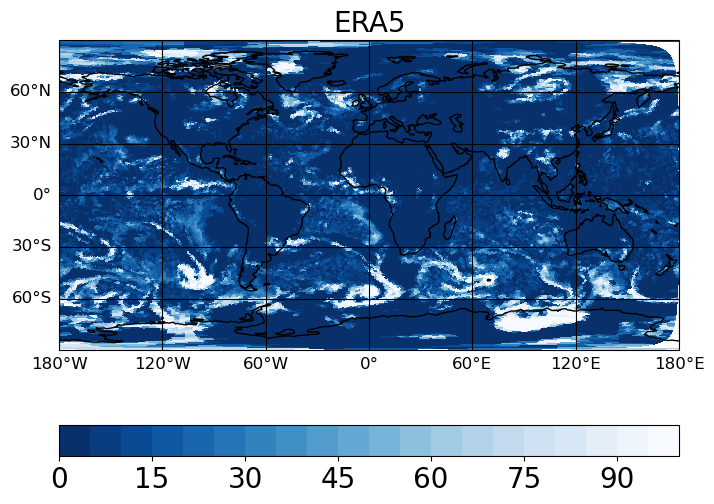

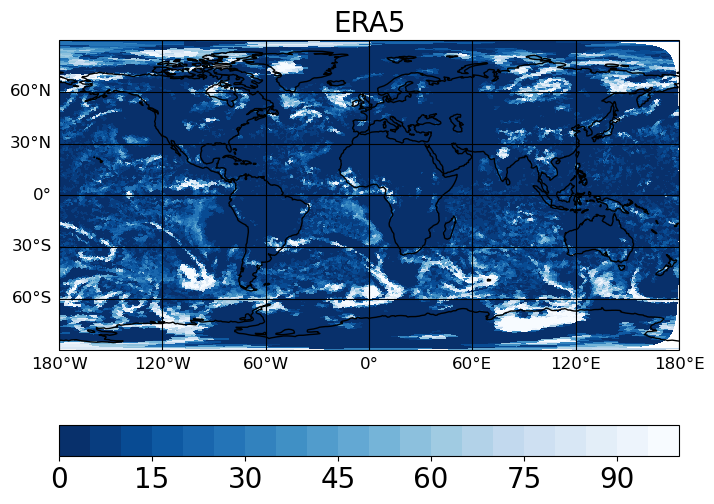

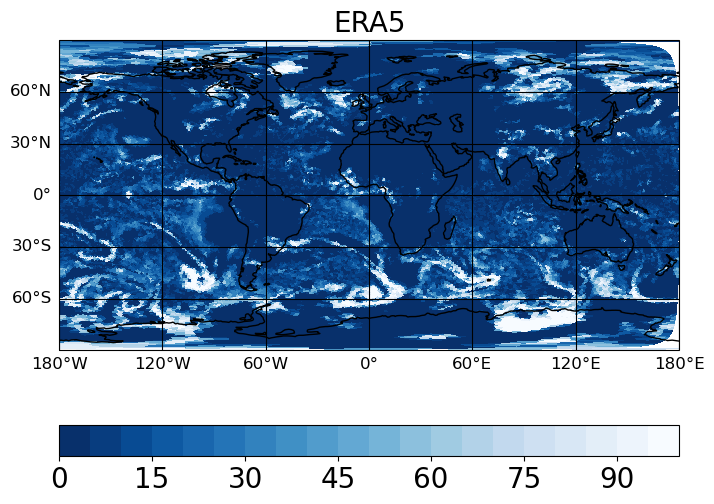

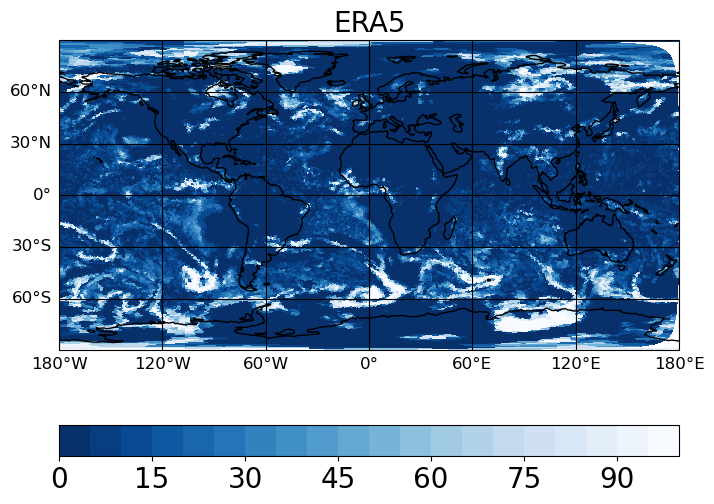

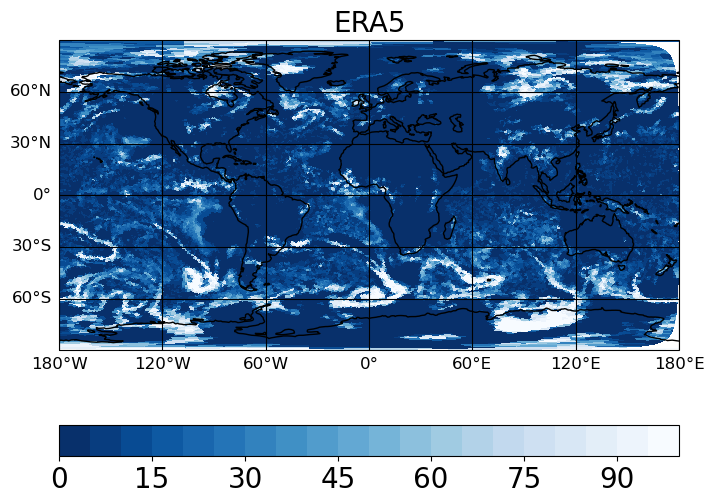

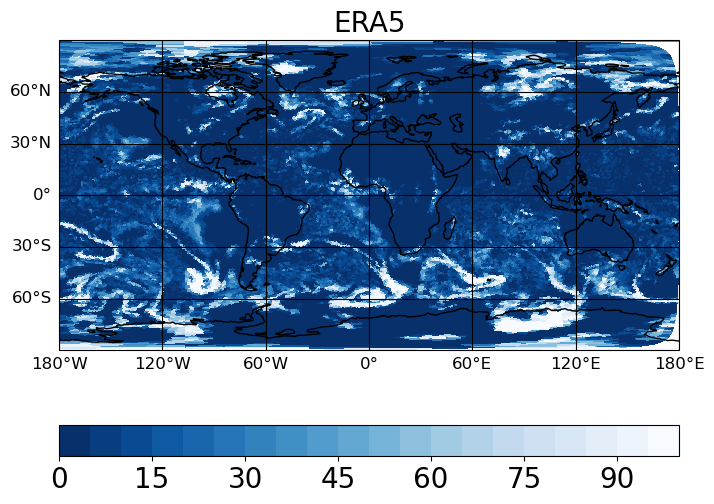

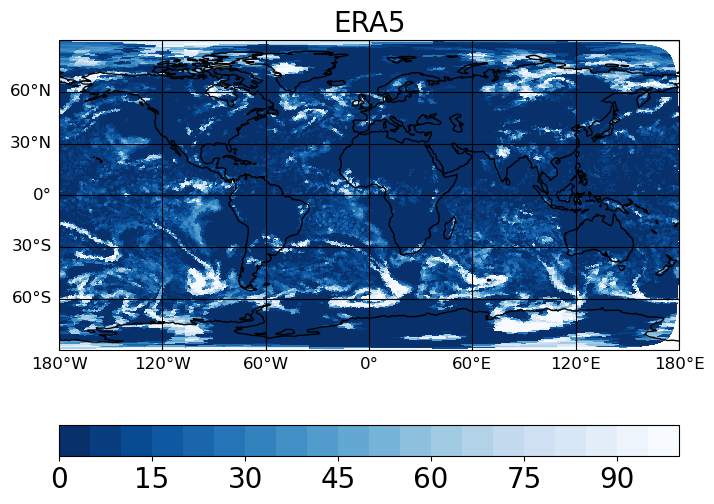

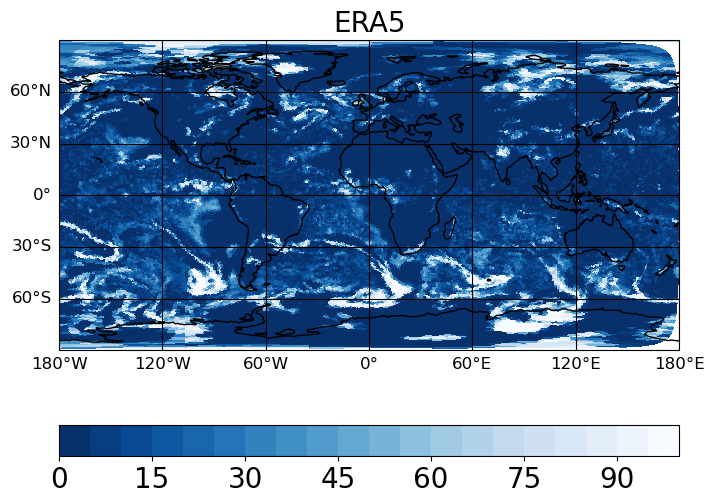

In [6]:
## 10 timesteps am 20 Aug

for kk in range(10):
    # Placeholder file
    DS_era5_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

    # xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
    DS_era5_new['I1'][0] = 100*DS_era5_2.cc.values[kk, 4:]

    coordlist = ["clat_bnds", "clon_bnds"]
    DS_era5_new = DS_era5_new.set_coords([coord for coord in DS_era5_new.data_vars if coord in coordlist]) 

    # Plotting the averaged xu-randall predictions here
    plot = psy.plot.mapplot(DS_era5_new, name=['I1'], height=[20], ax=(1,1), sort=['height'], \
                            title = 'ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)
    
    plot.show()

    # assert len(DS_dya_new.height) == len(DS_era5_new.height)

    # plt.savefig('for_pierre/era5_lv_41_20160811-0820_timmean.pdf')

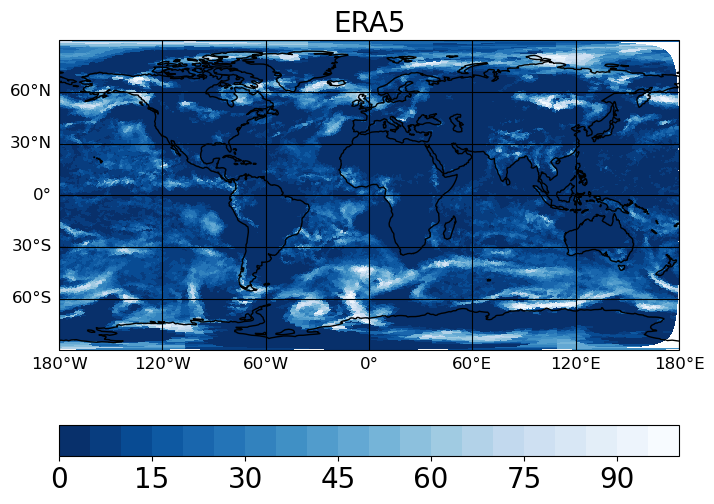

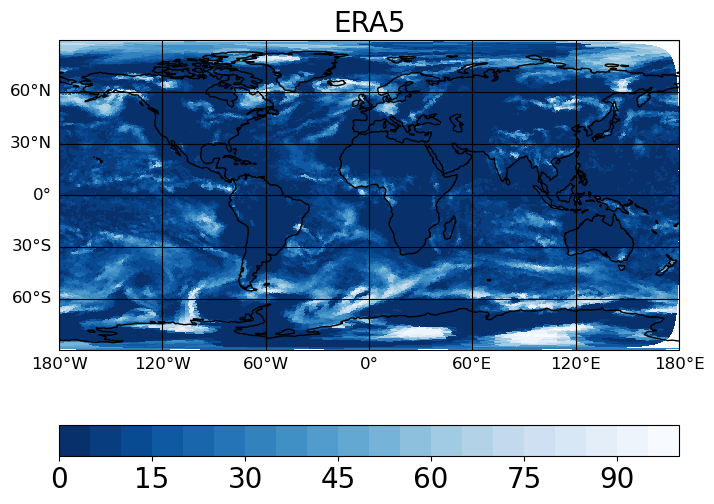

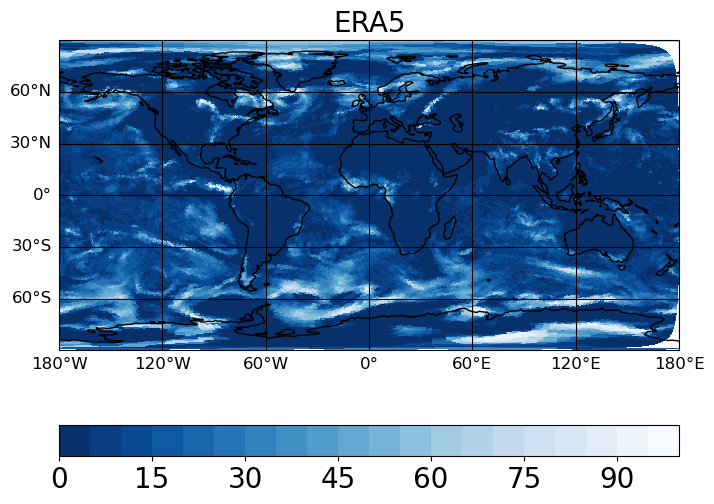

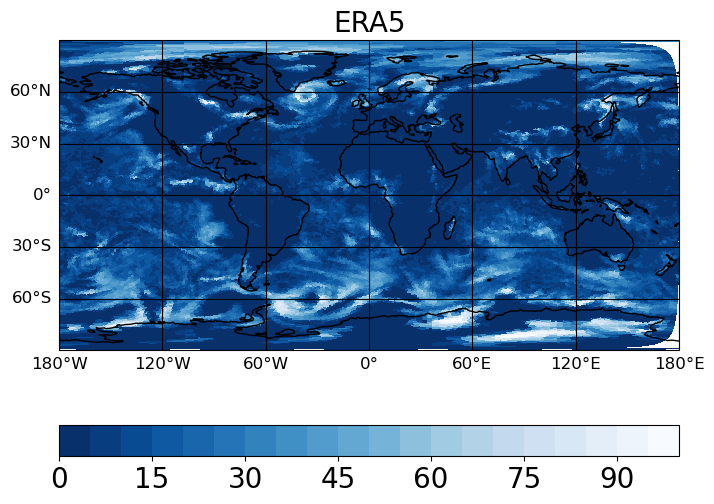

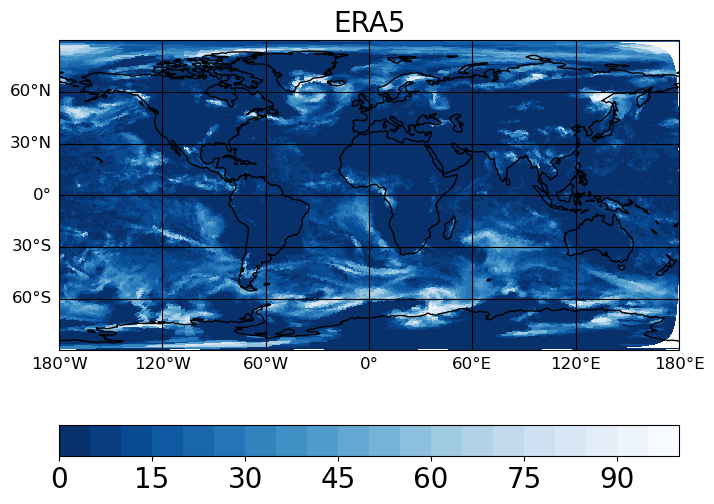

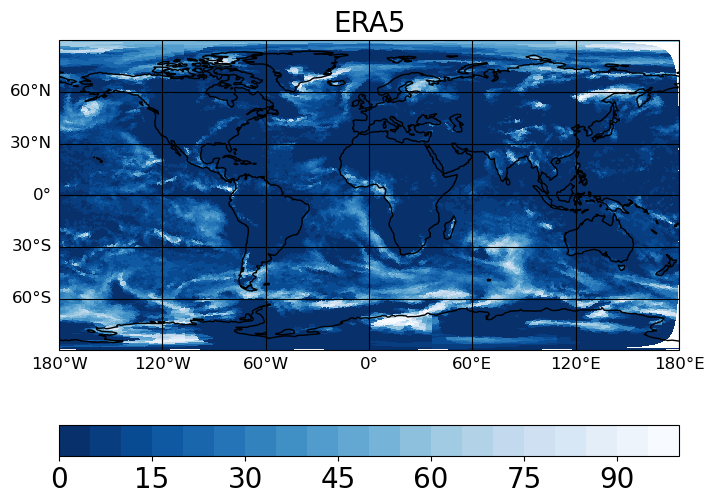

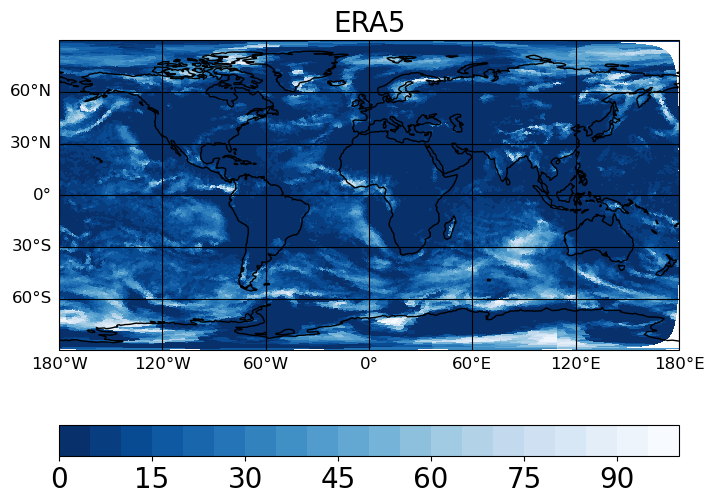

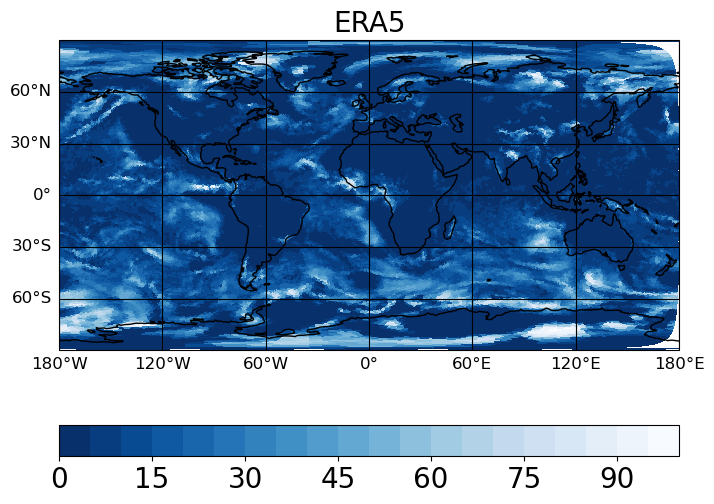

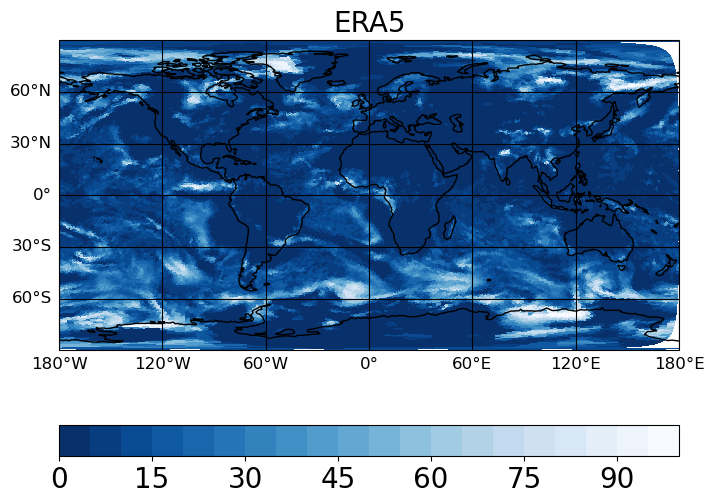

In [7]:
## 11 Aug bis 19 Aug

for kk in range(11, 20):
    # Placeholder file
    DS_era5_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

    # xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
    DS_era5_new['I1'][0] = 100*DS_era5_1.sel(time='2016-08-%d'%kk).mean(dim='time').cc.values[4:]

    coordlist = ["clat_bnds", "clon_bnds"]
    DS_era5_new = DS_era5_new.set_coords([coord for coord in DS_era5_new.data_vars if coord in coordlist]) 

    # Plotting the averaged xu-randall predictions here
    plot = psy.plot.mapplot(DS_era5_new, name=['I1'], height=[20], ax=(1,1), sort=['height'], \
                            title = 'ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

    plot.show()

    # assert len(DS_dya_new.height) == len(DS_era5_new.height)

    # plt.savefig('for_pierre/era5_lv_41_20160811-0820_timmean.pdf')

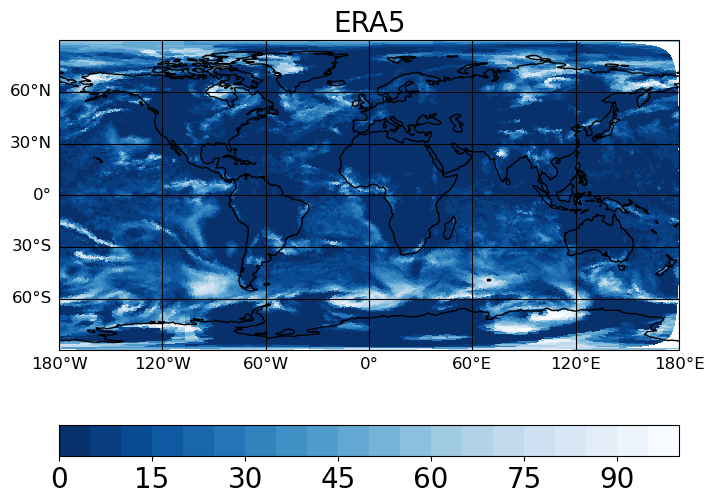

In [8]:
## 20 Aug

# Placeholder file
DS_era5_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_era5_new['I1'][0] = 100*DS_era5_2.mean(dim='time').cc.values[4:]

coordlist = ["clat_bnds", "clon_bnds"]
DS_era5_new = DS_era5_new.set_coords([coord for coord in DS_era5_new.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_era5_new, name=['I1'], height=[20], ax=(1,1), sort=['height'], \
                        title = 'ERA5', titlesize=20, cticksize=20, bounds=np.linspace(0, 100, 21), cmap=cmap)

plot.show()

# assert len(DS_dya_new.height) == len(DS_era5_new.height)

# plt.savefig('for_pierre/era5_lv_41_20160811-0820_timmean.pdf')

**Bias vs ERA5**

In [85]:
cmap = 'bwr'

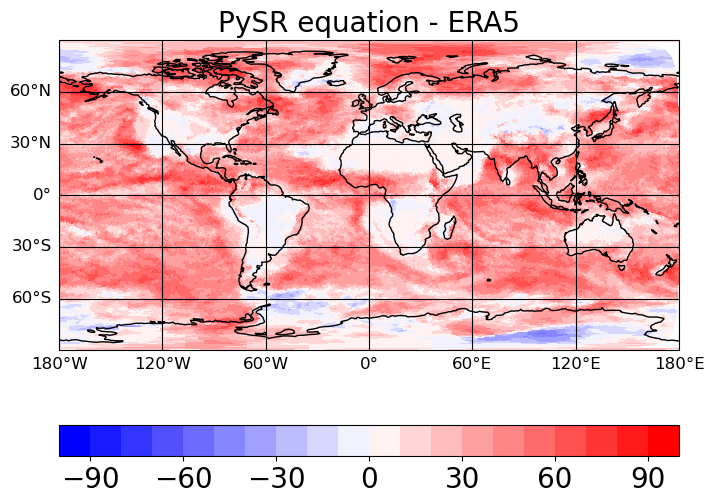

In [65]:
DS_pysr_equation = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_bounded_20160811-0820_timmean.nc')

bias_pysr_era5_vals = DS_pysr_equation.I1.values[0] - 100*DS_era5_timmean.cc.values[4:]

DS_pysr_equation.I1[0] = bias_pysr_era5_vals

coordlist = ["clat_bnds", "clon_bnds"]
DS_pysr_equation = DS_pysr_equation.set_coords([coord for coord in DS_pysr_equation.data_vars if coord in coordlist]) 

# This is the sum of I1, I2 and I3
plot = psy.plot.mapplot(DS_pysr_equation, name=['I1'], \
                        height=[20], time=[0], ax=(1, 1), sort=['height'], title = 'PySR equation - ERA5', titlesize=20, cticksize=20, \
                        bounds=np.linspace(-100, 100, 21), cmap=cmap)

plt.savefig('for_pierre/I123_lv_41_20160811-0820_timmean_pysr_era5_bias.pdf')

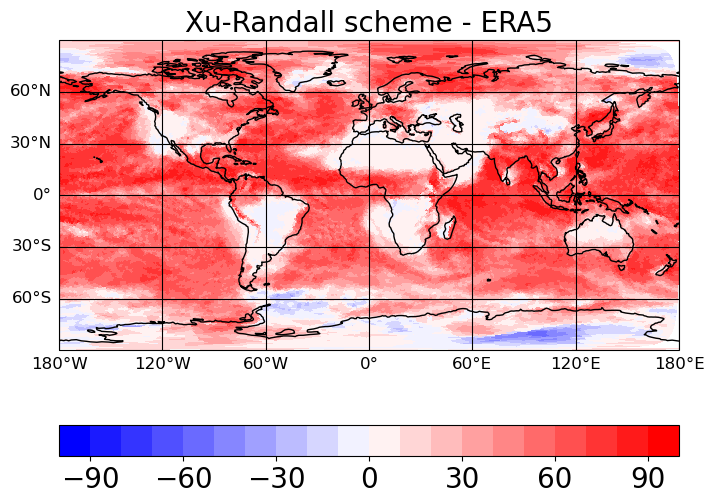

In [66]:
# Placeholder file
DS_xu_randall = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

timmean_xu_randall = np.mean(pred_xu_randall, axis=0)
assert timmean_xu_randall.shape == (27, 81920)

bias_xu_randall_era5 = timmean_xu_randall - 100*DS_era5_timmean.cc.values[4:]

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_xu_randall['I1'][0] = bias_xu_randall_era5

coordlist = ["clat_bnds", "clon_bnds"]
DS_xu_randall = DS_xu_randall.set_coords([coord for coord in DS_xu_randall.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_xu_randall, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'Xu-Randall scheme - ERA5', titlesize=20, cticksize=20, bounds=np.linspace(-100, 100, 21), cmap=cmap)

# assert len(xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I1/20160811-0820_timmean.nc').height) == len(DS_xu_randall.height)

plt.savefig('for_pierre/xu-randall_lv_41_20160811-0820_timmean_xurandall_era5_bias.pdf')

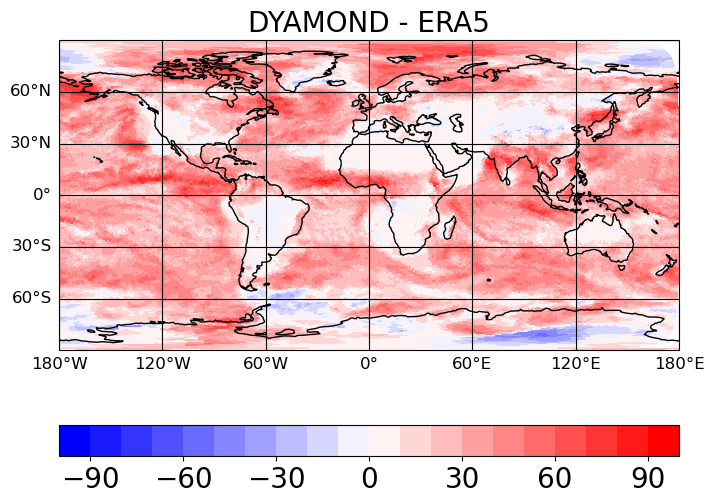

In [67]:
# Placeholder file
DS_dya_new = xr.load_dataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/I123/I123_added_20160811-0820_timmean.nc')

bias_dya_era5 = 100*DS_dya_timmean.cl_area.values[4:] - 100*DS_era5_timmean.cc.values[4:]

# xu_randall_da = xr.DataArray(timmean_xu_randall, coords={'height':np.arange(4, 31)}, dims=['height', 'cells'], name='xu_randall_clc')
DS_dya_new['I1'][0] = bias_dya_era5

coordlist = ["clat_bnds", "clon_bnds"]
DS_dya_new = DS_dya_new.set_coords([coord for coord in DS_dya_new.data_vars if coord in coordlist]) 

# Plotting the averaged xu-randall predictions here
plot = psy.plot.mapplot(DS_dya_new, name=['I1'], height=[20], ax=(1, 1), sort=['height'], \
                        title = 'DYAMOND - ERA5', titlesize=20, cticksize=20, bounds=np.linspace(-100, 100, 21), cmap=cmap)

assert len(DS_xu_randall.height) == len(DS_dya_new.height)

plt.savefig('for_pierre/dyamond_lv_41_20160811-0820_timmean_dya_era5_bias.pdf')